<a href="https://colab.research.google.com/github/djhsgfjk/collab/blob/main/Lab_5_%D0%92%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_ORB_%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B8_%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%81%D0%BE%D0%B1%D1%8B%D1%85_%D1%82%D0%BE%D1%87%D0%B5%D0%BA_ORB_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

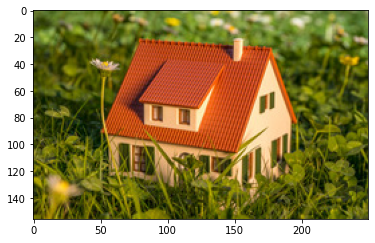

In [ ]:
import numpy as np
from PIL import Image
from pylab import *

image=np.array(Image.open('/house.jpg'), dtype=int)
figure()
imshow(image)
show()

In [ ]:
w = image.shape[0]
h = image.shape[1]
print(w, h)

156 250


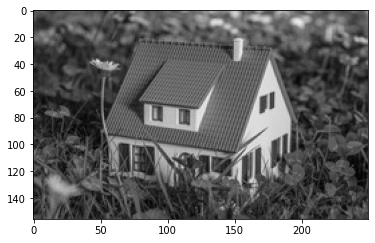

In [ ]:
halftoneImage = np.zeros((w,h), dtype=int)
for i in range(w):
    for j in range(h):
        halftoneImage[i][j] = mean(image[i,j,:])
figure()
imshow(halftoneImage, cmap='gray', vmin=0, vmax=255)
show()

# 1. Детектирование особых точек 

Детектирование особых точек на основе алгоритма FAST 

In [ ]:
def FAST(image, n, t):
  if n < 6 or n > 16:
    return

  w = image.shape[0]
  h = image.shape[1]

  features = []
  for i in range(3, w-3):
    for j in range(3, h-3):
      p = image[i, j]
      B1 = np.concatenate((image[i:i+2, j-3], image[i+2, j-2], image[i+3, j-1:j+2], image[i+2, j+2], image[i:i+2, j+3]), axis=None)
      B2 = np.concatenate((image[i+3, j:j+2], image[i+2, j+2], image[i-1:i+2, j+3], image[i-2, j+2], image[i-3, j:j+2]), axis=None)
      B =  np.concatenate((image[i-1:i+2, j-3], image[i+2, j-2], image[i+3, j-1:j+2], image[i+2, j+2], image[i-1:i+2, j+3], image[i-2, j+2], image[i-3, j-1:j+2], image[i-2, j-2]), axis=None)
      count = 0
      if (all(q > p+t for q in B1) or all(q > p+t for q in B2)):
        for q in np.concatenate((B, B), axis=None):
          if q > p+t:
            count += 1
          else:
            count = 0
          if count >= n:
            features.append((i, j))
            break
      elif (all(q < p-t for q in B1) or all(q < p-t for q in B2)):
        for q in np.concatenate((B, B), axis=None):
          if q < p-t:
            count += 1
          else:
            count = 0
          if count >= n:
            features.append((i, j))
            break
  return features

In [ ]:
F = FAST(halftoneImage, 12, 40)
print(F)

[(18, 228), (19, 228), (19, 229), (24, 97), (26, 127), (61, 178), (61, 179), (62, 177), (62, 178), (62, 179), (63, 178), (63, 179), (64, 173), (65, 172), (71, 177), (71, 178), (72, 177), (72, 178), (72, 179), (73, 177), (73, 178), (75, 170), (76, 170), (76, 171), (77, 170), (81, 94), (88, 173), (88, 174), (89, 172), (90, 171), (91, 169), (91, 194), (92, 168), (92, 188), (93, 167), (93, 187), (93, 188), (94, 187), (94, 188), (95, 188), (96, 183), (101, 16), (101, 75), (103, 168), (103, 169), (104, 167), (104, 168), (105, 168), (105, 193), (106, 150), (107, 113), (107, 162), (110, 105), (110, 106), (111, 106), (111, 182), (112, 146), (113, 146), (115, 12), (115, 103), (115, 179), (116, 173), (116, 179), (117, 178), (118, 55), (120, 130), (120, 146), (120, 152), (123, 48), (125, 68), (142, 62), (147, 245), (152, 25)]


In [ ]:
len(F)

73

Полученные по алгоритму FAST точки фильтруем по критерию угловых точек Харриса. 

In [ ]:
def build_W(sigma2):
  const1 = 2*sigma2
  const2 = 2*np.pi*sigma2

  G = np.zeros((5, 5), dtype=np.float64)

  for i in range(5):
    for j in range(5):
      G[i, j] = np.power(np.e, -((i-3)**2 + (j-3)**2)/const1)/const2

  G /= np.sum(G)
  return G 

In [ ]:
W = build_W(100)
print(W)

[[0.03766047 0.03861385 0.03919742 0.0393939  0.03919742]
 [0.03861385 0.03959136 0.04018971 0.04039116 0.04018971]
 [0.03919742 0.04018971 0.0407971  0.04100159 0.0407971 ]
 [0.0393939  0.04039116 0.04100159 0.04120711 0.04100159]
 [0.03919742 0.04018971 0.0407971  0.04100159 0.0407971 ]]


In [ ]:
def get_gradient(image):
  width = image.shape[0]
  height = image.shape[1]

  imageCopy = np.zeros((width+1, height+1), dtype=int)

  for i in range(width):
    for j in range(height):
      imageCopy[i+1, j+1] = image[i, j]

  gradient = np.zeros((width+1, height+1, 2), dtype=float)

  for i in range(1, width):
    for j in range(1, height):
      gradient[i, j, 0] = (imageCopy[i+1, j]-imageCopy[i-1, j] + imageCopy[i+1, j-1]-imageCopy[i-1, j-1] + imageCopy[i+1, j+1]-imageCopy[i-1, j+1])/6
      gradient[i, j, 1] = (imageCopy[i, j+1]-imageCopy[i, j-1] + imageCopy[i-1, j+1]-imageCopy[i-1, j-1] + imageCopy[i+1, j+1]-imageCopy[i+1, j-1])/6

  return gradient[1:width+1, 1:height+1, :]

In [ ]:
grad = get_gradient(halftoneImage)
print(grad)

[[[ 30.16666667  30.66666667]
  [ 45.33333333  -0.16666667]
  [ 45.33333333   2.        ]
  ...
  [ 54.83333333  10.66666667]
  [ 63.5         15.83333333]
  [  0.           0.        ]]

 [[ -3.16666667  45.        ]
  [ -5.16666667  -0.5       ]
  [ -6.66666667   1.83333333]
  ...
  [ -5.          14.16666667]
  [ -7.83333333  20.83333333]
  [  0.           0.        ]]

 [[  0.16666667  44.16666667]
  [ -0.5         -1.33333333]
  [ -2.          -0.83333333]
  ...
  [ -7.5         12.        ]
  [-10.83333333  16.83333333]
  [  0.           0.        ]]

 ...

 [[ 14.66666667  35.66666667]
  [ 20.33333333   0.83333333]
  [ 14.66666667   0.33333333]
  ...
  [ -0.83333333  -0.5       ]
  [  0.66666667   0.5       ]
  [  0.           0.        ]]

 [[  3.66666667  41.16666667]
  [  4.33333333  -2.5       ]
  [  1.33333333  -3.33333333]
  ...
  [ -5.83333333   0.16666667]
  [ -5.83333333  -1.33333333]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.    

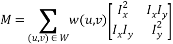

In [ ]:
def get_M(I, grad, u, v):
  w = image.shape[0]
  h = image.shape[1]

  M = np.zeros((2, 2), dtype=float)
  for x in range(u-2, u+3):
    for y in range(v-2, v+3):
      Ix = grad[x, y, 0]
      Iy = grad[x, y, 1]
      A = np.array([[Ix**2, Ix*Iy], [Ix*Iy, Iy**2]], dtype=float)
      A.shape = (2, 2)
      new = np.sum(W * I[i-2:i+3, j-2:j+3]) * A
      M = np.add(M, new)
  return M

In [ ]:
M = []
for p in F:
  x, y = p
  m = get_M(halftoneImage, grad, x, y)
  M.append(m)
print(M)

[array([[1053603.86054221, -462232.18718895],
       [-462232.18718895,  572624.1669094 ]]), array([[ 977372.25320757, -394496.59868091],
       [-394496.59868091,  512705.66592216]]), array([[1004942.11562501, -468391.33196303],
       [-468391.33196303,  607358.44255369]]), array([[763992.77110165, -73992.25932605],
       [-73992.25932605, 200325.99622665]]), array([[530039.0447291 , -42761.4192597 ],
       [-42761.4192597 , 198435.49137516]]), array([[3241585.65200721,  752796.03105864],
       [ 752796.03105864, 4476374.14715482]]), array([[2878601.21851936,  311468.17628498],
       [ 311468.17628498, 3606610.63041413]]), array([[3189322.94546814, 1047444.71576814],
       [1047444.71576814, 3542025.88332522]]), array([[3236480.53870787,  720916.26770003],
       [ 720916.26770003, 6344579.29359271]]), array([[2870724.11497152,  317668.58207764],
       [ 317668.58207764, 4970996.23393216]]), array([[2310459.49862884,  698380.24954983],
       [ 698380.24954983, 8074927.62594002

На основе значения критерия R = det(M) - k*(tr(M))^2 принять решение о фильтрации ключевой точки. Параметр k выбрать из интервала [0.04, 0.06]. 

In [ ]:
def get_R(m, k):
  r = np.linalg.det(m) - k * np.trace(m)**2
  return r

In [ ]:
k = 0.04
R = []
for m in M:
  r = get_R(m, k)
  R.append(r)

print(R)

[142678682902.17575, 129001519991.97502, 144243498039.27368, 55476208978.56415, 41275818845.69273, 5810756696579.68, 4323781134440.9663, 4215428187976.827, 8213907649351.755, 5885429466982.831, 6963559991673.194, 4652661242332.59, 2715419466113.2393, 3917980554964.8047, 4165047635869.83, 5922731370237.739, 5571654220492.536, 7548421409467.886, 3935367861449.659, 4134807941761.606, 5388950232042.304, 6867659680924.939, 5707045860975.598, 4552736510545.291, 3906979580914.8857, 3303710526743.203, 92711639861.7916, 68941480195.4372, 93009641409.95712, 11176450054.856415, -225986142753.08615, 177900025487.36902, -361869177738.1723, 3952953672043.564, -495110206272.7432, 3740788148177.9165, 5966242065819.214, 4536576636328.878, 6506908410071.824, 1865201938598.512, 2336618163702.5044, 46806402123.64577, 1305908054096.179, 4308828019765.3433, 3143045587704.712, 3048869171927.8804, 4901538526088.57, 2777700116225.499, 464502142258.1727, 566350013562.09, 1041373605225.4023, 1249865222060.1902, 

Отфильтровать точки по убыванию значения критерия Харриса и выбрать первые N точек.

In [ ]:
N = 2*len(F)//3
point_R = dict()
for i in range(len(F)):
  point_R[F[i]] = R[i]
  
points = list(dict(sorted(point_R.items(), key=lambda item: item[1], reverse=True)[0:N]).keys())
print(len(points), points)

48 [(62, 178), (72, 178), (63, 178), (75, 170), (94, 188), (93, 188), (71, 178), (62, 179), (61, 178), (76, 170), (72, 177), (73, 178), (104, 168), (63, 179), (76, 171), (94, 187), (61, 179), (103, 168), (62, 177), (71, 177), (73, 177), (92, 188), (72, 179), (65, 172), (77, 170), (93, 187), (81, 94), (103, 169), (116, 179), (104, 167), (105, 168), (115, 179), (64, 173), (111, 106), (96, 183), (117, 178), (120, 130), (95, 188), (110, 106), (110, 105), (101, 75), (107, 162), (107, 113), (112, 146), (113, 146), (106, 150), (105, 193), (118, 55)]


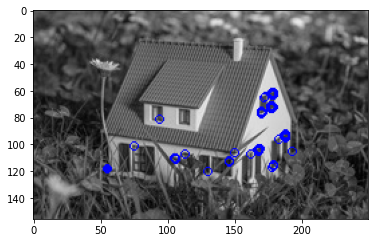

In [ ]:
imageWithFeatures = np.zeros_like(image, dtype=int)
for i in range(w):
    for j in range(h):
        imageWithFeatures[i, j, :] = halftoneImage[i, j]

color = [0, 0, 255]
for i, j in points:
  imageWithFeatures[i-1:i+2, j-3] = color
  imageWithFeatures[i+2, j-2] = color
  imageWithFeatures[i+3, j-1:j+2] = color
  imageWithFeatures[i+2, j+2] = color
  imageWithFeatures[i-1:i+2, j+3] = color
  imageWithFeatures[i-2, j+2] = color
  imageWithFeatures[i-3, j-1:j+2] = color
  imageWithFeatures[i-2, j-2] = color
  imageWithFeatures[x-2:x+3, y-2:y+3] = color 

figure()
imshow(imageWithFeatures, vmin=0, vmax=255)
show()

# 2. Описание ключевых точек (построение дескриптора)

Для каждой оставшейся после фильтрации точки вычислить ориентацию на основе моментов изображения m01,m10:

angle = atan2(m01; m10).


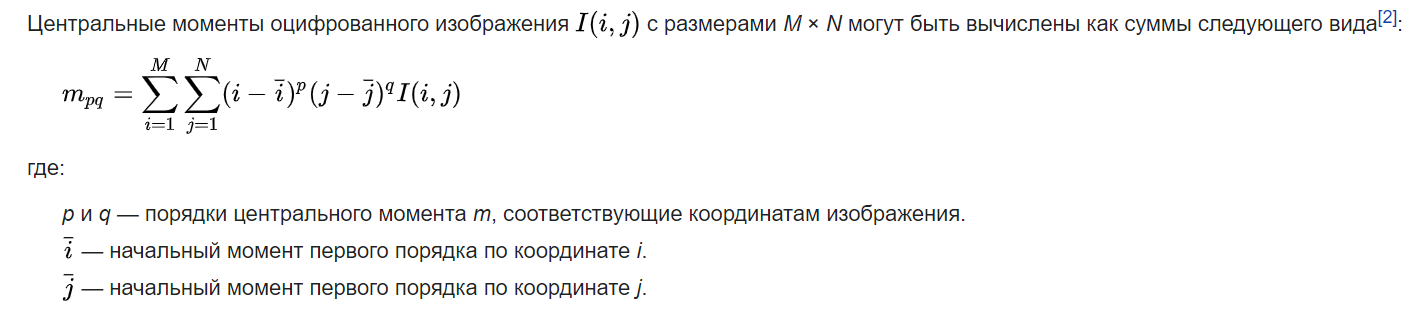

In [ ]:
def get_moment(I, p, q, x, y, r):
  w = I.shape[0]
  h = I.shape[1]

  ci = w//2
  cj = h//2

  m = 0
  for i in range(max(0, x-r), min(w, x+r+1)):
      for j in range(max(0, y-r), min(h, y+r+1)):
        m += (i-ci)**p * (j-cj)**q * I[i, j]
  return m

In [ ]:
import math

In [ ]:
patch_size = 31
r = patch_size

angles = []
for x, y in points:
  m01 = get_moment(halftoneImage, 0, 1, x, y, r)
  m10 = get_moment(halftoneImage, 1, 0, x, y, r)
  a = math.atan2(m01, m10) % (2*np.pi)
  angles.append(a)

print(angles)

[1.8208408256375137, 1.647419662868959, 1.802312851139717, 1.6029328057455838, 1.3279260015148233, 1.3417991887832312, 1.6638066307273025, 1.8175320915315207, 1.839626553482187, 1.5837000014650977, 1.6488365310346105, 1.6307879948364477, 1.0902184964025534, 1.7991245004701677, 1.5833179361100926, 1.3243381332171245, 1.8361822937630685, 1.105131006775189, 1.8240556468999964, 1.6654362352042762, 1.6319362266514166, 1.3562033140604504, 1.646269451015837, 1.783372794490391, 1.5643061869832255, 1.3383913703800936, 4.840281529831432, 1.110760761344341, 0.9834158293583705, 1.0841904767360442, 1.075039320759627, 0.996355333631163, 1.799485233775021, 5.704802896344978, 1.2721649477041868, 0.964526142234684, 0.16764953678160105, 1.314374137027384, 5.690746867525992, 5.667652732496634, 5.156903469809031, 0.9958314577865933, 5.817576623390489, 0.6829901117723705, 0.6681968529084327, 0.8470236731550016, 1.2109522754677082, 5.229787712101656]


Перед построением дескриптора изображение необходимо сгладить с помощью фильтра Гаусса

In [ ]:
def build_G(sigma2_e):
  const1 = 2*sigma2_e
  const2 = 2*np.pi*sigma2_e

  G = np.zeros(9, dtype=np.float64)
  G.shape = (3, 3)

  for i in range(3):
    for j in range(3):
      G[i, j] = np.power(np.e, -((i-3//2)**2 + (j-3//2)**2)/const1)/const2

  G /= np.sum(G)
  return G

G = build_G(100)
print(G)

def Gaussian_filtering(image_e):
  width_e = image_e.shape[0]
  height_e = image_e.shape[1]

  gaussImage = np.zeros(width_e*height_e, dtype=int)
  gaussImage.shape = (width_e, height_e)

  image_eCopy = np.zeros((width_e+1)*(height_e+1), dtype=int)
  image_eCopy.shape = ((width_e+1),(height_e+1))


  for i in range(width_e):
      for j in range(height_e):
        image_eCopy[i+1, j+1] = image_e[i, j]

  for i in range(1, width_e-1):
      for j in range(1, height_e-1):
        gaussImage[i, j] = np.sum(G * image_eCopy[i-1:i+2, j-1:j+2])

  gaussImage = clip(gaussImage, 0, 255)     
  return gaussImage 

[[0.11074074 0.11129583 0.11074074]
 [0.11129583 0.1118537  0.11129583]
 [0.11074074 0.11129583 0.11074074]]


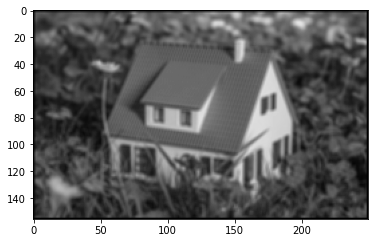

In [ ]:
gaussImage = Gaussian_filtering(halftoneImage)
figure()
imshow(gaussImage, cmap='gray', vmin=0, vmax=255)

BRIEF представляет из себя бинарный вектор, каждый элемент которого получается из сравнения
интенсивностей пикселей из области вокруг особой точки.

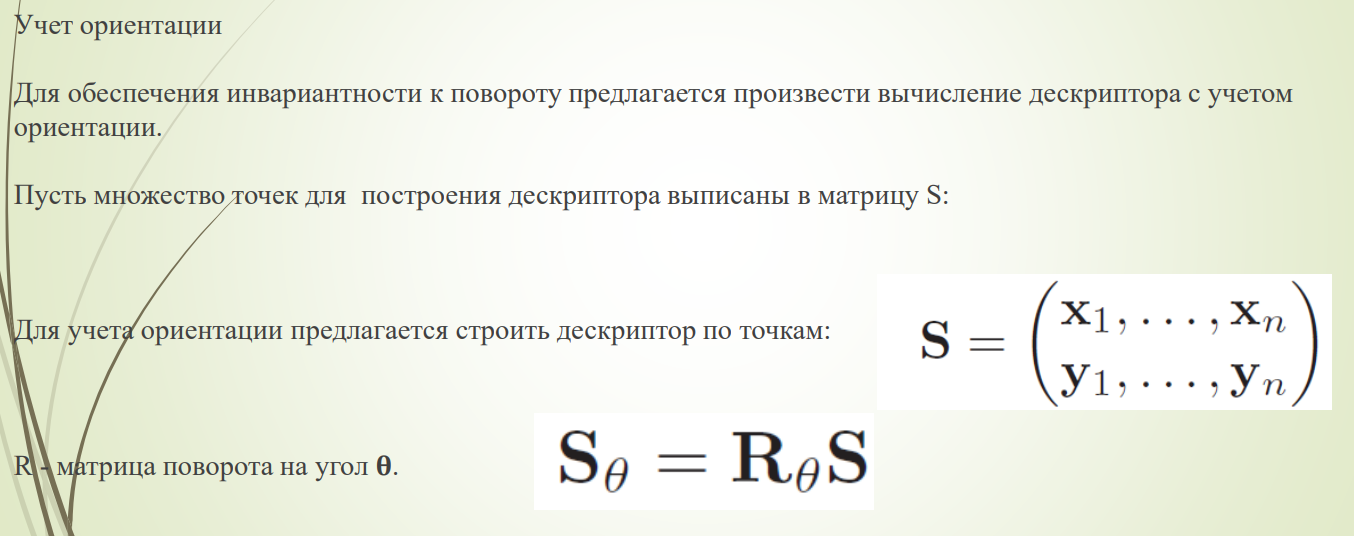

In [ ]:
theta = [2*k*np.pi/30 for k in range(30)]
print(len(theta), theta)

30 [0.0, 0.20943951023931953, 0.41887902047863906, 0.6283185307179586, 0.8377580409572781, 1.0471975511965976, 1.2566370614359172, 1.4660765716752369, 1.6755160819145563, 1.8849555921538759, 2.0943951023931953, 2.3038346126325147, 2.5132741228718345, 2.7227136331111543, 2.9321531433504737, 3.1415926535897927, 3.3510321638291125, 3.5604716740684323, 3.7699111843077517, 3.979350694547071, 4.1887902047863905, 4.39822971502571, 4.607669225265029, 4.817108735504349, 5.026548245743669, 5.235987755982989, 5.445427266222309, 5.654866776461628, 5.8643062867009474, 6.073745796940267]


In [ ]:
Rt = []
for t in theta:
  rt = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
  Rt.append(rt)

print(Rt)

[array([[ 1., -0.],
       [ 0.,  1.]]), array([[ 0.9781476 , -0.20791169],
       [ 0.20791169,  0.9781476 ]]), array([[ 0.91354546, -0.40673664],
       [ 0.40673664,  0.91354546]]), array([[ 0.80901699, -0.58778525],
       [ 0.58778525,  0.80901699]]), array([[ 0.66913061, -0.74314483],
       [ 0.74314483,  0.66913061]]), array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]]), array([[ 0.30901699, -0.95105652],
       [ 0.95105652,  0.30901699]]), array([[ 0.10452846, -0.9945219 ],
       [ 0.9945219 ,  0.10452846]]), array([[-0.10452846, -0.9945219 ],
       [ 0.9945219 , -0.10452846]]), array([[-0.30901699, -0.95105652],
       [ 0.95105652, -0.30901699]]), array([[-0.5      , -0.8660254],
       [ 0.8660254, -0.5      ]]), array([[-0.66913061, -0.74314483],
       [ 0.74314483, -0.66913061]]), array([[-0.80901699, -0.58778525],
       [ 0.58778525, -0.80901699]]), array([[-0.91354546, -0.40673664],
       [ 0.40673664, -0.91354546]]), array([[-0.9781476 , -0.2079116

In [ ]:
n = 256 #длина дескриптора
S = (np.pi/5) * np.random.randn(n, 2, 2)
print(S)

[[[-0.11477978 -1.2391257 ]
  [-0.46335777  0.41383088]]

 [[-0.25518622 -0.2080648 ]
  [ 0.03869001 -0.58313118]]

 [[-0.77757342  0.35760622]
  [-0.5404154  -0.42194799]]

 ...

 [[-0.20445623 -0.6498395 ]
  [-0.12612925 -0.27060452]]

 [[-0.92437899 -1.02911332]
  [-0.13631835  0.31814162]]

 [[-0.45278122 -0.31780651]
  [ 0.35798777 -0.91516542]]]


In [ ]:
St = []
for rt in Rt:
  st = []
  for i in range(S.shape[0]):
    st.append([rt.dot(S[i, 0]), rt.dot(S[i, 1])])
  St.append(st)

print(St)

[[[array([-0.11477978, -1.2391257 ]), array([-0.46335777,  0.41383088])], [array([-0.25518622, -0.2080648 ]), array([ 0.03869001, -0.58313118])], [array([-0.77757342,  0.35760622]), array([-0.5404154 , -0.42194799])], [array([ 0.38131597, -1.10606758]), array([-0.56851028, -0.69327379])], [array([-0.28824289,  0.76152172]), array([-0.93492197,  0.25267575])], [array([-0.4094676 ,  0.32091194]), array([-0.21174934, -0.79426041])], [array([-0.16476323,  0.80869354]), array([ 0.39755301, -0.7478126 ])], [array([ 1.25850504, -0.79140494]), array([-0.37181804, -0.9319979 ])], [array([-0.03619653,  0.52197961]), array([ 0.31207537, -0.36742548])], [array([-1.17562248, -0.56921649]), array([-0.50869367,  0.67103213])], [array([1.0032289 , 0.55602663]), array([ 0.78630174, -0.46499753])], [array([-0.04927775,  0.39092951]), array([-1.31124234,  1.1544532 ])], [array([-0.11825038, -0.65972427]), array([-0.30085059,  0.25387992])], [array([-0.4885515 , -0.21313083]), array([-0.09163746,  1.33511

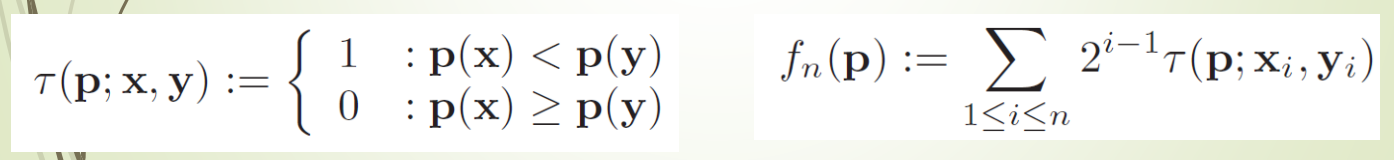

In [ ]:
def tau(p, c, i, j):
  xi, yi = np.array((i * patch_size//2 + c), dtype=int)
  xj, yj = np.array((j * patch_size//2 + c), dtype=int)
  # print(xi, yi)
  # print(xj, yj)
  if p[xi, yi] < p[xj, yj]:
    return '1'
  return '0'

descriptor = dict()
for j in range(len(points)):
  c = points[j]
  #print("center: ", c[0], c[1])

  t = len(theta)-1
  for i in range(len(theta)):
    if angles[j] < theta[i]:
      t = i-1
      break
  s = St[t]

  f = ""
  for i in range(n-1, -1, -1):
    f += tau(gaussImage, c, S[i, 0], S[i, 1])
  descriptor[c] = f

In [ ]:
f = open("descriptor.txt", "w")
for x, y in descriptor:
  line = "(" + str(x) + ", " + str(y) + "): " + str(descriptor[(x, y)]) + "\n"
  f.write(line)
f.close()

In [ ]:
f = open("descriptor.txt", "r")
print(f.read())

(62, 178): 0111101101010000011010111110100111000010101110000011100101110111101101000010110110011011011111100000100001111001011001001111100110011101010011111011101101001110000001010001111110111000001110100101101100111111010111111100010011111000001011111101000001011101
(72, 178): 0101001110111110000011100101100111000011100010110011100100111001010111000101010001011011011010110011110000101000011011001111011100110011000011101000001100100010000101001000000110011110000011101100010000110111010011111100101010101111010011110100011001011111
(63, 178): 0111101101011100001010111110100111000011101110000010100101110101101101000010110110011011011111100010100001101001011000001111100100001101010011111011111101001110000001010001101110111000001110100101100000111111010111111100010011111000000011011101000001011101
(75, 170): 00111110101111100000110000000011010100000001101111101001100100111101011011001110110110001100101010101110011000000010101000110111011101110000011011000001101100100101110100010001010010100